In [1]:
import pyshark as ps
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, find_peaks_cwt
from scipy.stats import stats
import numpy as np
import re
import pprint as pp
from datetime import datetime
from collections import OrderedDict, defaultdict, deque
from scalogram import *

In [9]:
cap = ps.FileCapture("../../../shared/netflix_3.pcapng")
#cap.load_packets()

In [10]:
def get_info(up_pkts, down_pkts):
    

    up_ordered = OrderedDict(sorted(up_pkts.items(), key=lambda t: t[0]))
    down_ordered= OrderedDict(sorted(down_pkts.items(), key=lambda t: t[0]))    

    result = {}
    up = defaultdict(list)
    down = defaultdict(list)
    byte_count = defaultdict(list)

    for pkts in up_ordered.values():
        up['byte_count'].append(sum(int(pkt.captured_length) for pkt in pkts))
        up['packet_count'].append(len(pkts))
    for pkts in down_ordered.values():
        down['byte_count'].append(sum(int(pkt.captured_length) for pkt in pkts))
        down['packet_count'].append(len(pkts))
    result['up'] = up
    result['down'] = down
    return result

In [11]:
private_ip_pattern = re.compile("(^127\.)|(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)")
step = 30 # batches of 30 seconds
info = []
window = 1 # 1 second
window = 1/window
batch_time = int(cap[0].sniff_time.timestamp() * window)
last_timestamp_up = int(cap[0].sniff_time.timestamp() * window)
last_timestamp_down = int(cap[0].sniff_time.timestamp() * window)

download = defaultdict(list)
upload = defaultdict(list)
download[last_timestamp_up] = upload[last_timestamp_up] = []

for pkt in cap:
    if hasattr(pkt, 'ip'):
        if (int(pkt.sniff_time.timestamp() * window) - batch_time) >= step:
            info.append(get_info(upload, download))
            batch_time = int(pkt.sniff_time.timestamp() * window)
            download = defaultdict(list)
            upload = defaultdict(list)
            download[last_timestamp_up] = upload[last_timestamp_up] = []
            last_timestamp_up = int(pkt.sniff_time.timestamp() * window)
            last_timestamp_down = int(pkt.sniff_time.timestamp() * window)
        if private_ip_pattern.match(pkt.ip.src.get_default_value()):
            time_diff = int(pkt.sniff_time.timestamp() * window) - last_timestamp_up
            if time_diff > 1:
                for i in range(1, time_diff):
                    upload[last_timestamp_up + i] = []
            last_timestamp_up = int(pkt.sniff_time.timestamp() * window)
            upload[int(pkt.sniff_time.timestamp() * window)].append(pkt)
        elif private_ip_pattern.match(pkt.ip.dst.get_default_value()):
            time_diff = int(pkt.sniff_time.timestamp() * window) - last_timestamp_down
            if time_diff > 1:
                for i in range(1, time_diff):
                    download[last_timestamp_down + i] = []
            last_timestamp_down = int(pkt.sniff_time.timestamp() * window)
            download[int(pkt.sniff_time.timestamp() * window)].append(pkt)
        else:
            print("Curious!\n", pkt)
        
    elif hasattr(pkt, 'ipv6'):
        print("not yet implemented")
        # TODO

In [12]:
#N=len(data)

def calc_scalogram(data, scales):
    
    S,scales= scalogramCWT(data,scales)
    return S


In [13]:
def show_scalo(data, scales, colors):
    for i in range (0, len(data)):
        plt.plot(scales, data[i], colors[i], lw=3)
    plt.show()

In [14]:
scalos_up = []
scalos_down = []

N = step
dj=1/128
s0=2
J=1/dj * np.log2(0.5*N/s0)
scales=s0*2**(np.arange(J)*dj)

for idx, sample in enumerate(info):
    scalos_up.append(
        (calc_scalogram(np.asarray(sample['up']['byte_count']), scales),
         calc_scalogram(np.asarray(sample['up']['packet_count']), scales))
    )
    scalos_down.append(
        (calc_scalogram(np.asarray(sample['down']['byte_count']), scales),
         calc_scalogram(np.asarray(sample['down']['packet_count']), scales))
    )
#    show_scalo([scalos_down[idx], scalos_up[idx]], scales, ['r', 'b'])
#smooth_down = np.convolve(scalo_down, np.ones(len(scalo_down)), mode='same')
#smooth_up = np.convolve(scalo_up, np.ones(len(scalo_up)), mode='same')
#show_scalo([smooth_down, smooth_up], scales, ['r', 'b'])

#scalo, scales = calc_and_show(np.asarray(stats['down']['packet_count']), 'r')
#scalo, scales = calc_and_show(np.asarray(stats['up']['packet_count']), 'b')

In [15]:
# Get top X spikes from scalogram, sorted by value
def get_spikes(scalo, comparator):
    len(scalo)
    spikes = deque([(-1,-1)] * 5, maxlen=5)
    #aux = argrelextrema(scalo, comparator, order=int(len(scalo)/10))
    aux = argrelextrema(scalo, comparator)
    if aux[0].size:
        for x in np.nditer(aux) or []:
            spikes.append((scalo[x], scales[x]))
    ordered = sorted(spikes, key=lambda x: x[1], reverse=True)
    values = np.hstack(zip(*ordered))
    return values

In [16]:
local_max_up_bytes = []
local_min_up_bytes = []
local_max_up_packet = []
local_min_up_packet = []
local_max_down_bytes = []
local_min_down_bytes = []
local_max_down_packet = []
local_min_down_packet = []


for scalo in scalos_up:
    local_max_up_bytes.append(get_spikes(scalo[0], np.greater))
    local_min_up_bytes.append(get_spikes(scalo[0], np.less))
    local_max_up_packet.append(get_spikes(scalo[1], np.greater))
    local_min_up_packet.append(get_spikes(scalo[1], np.less))

for scalo in scalos_down:
    local_max_down_bytes.append(get_spikes(scalo[0], np.greater))
    local_min_down_bytes.append(get_spikes(scalo[0], np.less))
    local_max_down_packet.append(get_spikes(scalo[1], np.greater))
    local_min_down_packet.append(get_spikes(scalo[1], np.less))

In [22]:
def get_stats_numpy(data):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    var = np.var(data)
    skew = stats.skew(data)
    kurt = stats.kurtosis(data)
    pc = [25,50,75]
    percentiles = np.array(np.percentile(data, pc))
    
    #print("Mean: " + str(mean))
    #print("Media: " + str(median))
    #print("StdDev: " + str(std))
    #print("Variance: " + str(var))
    #print("Skewness: " + str(skew))
    #print("Kurtosis: " + str(kurt))
    #print("Pc25: " + str(percentiles[0]))
    #print("Pc50: " + str(percentiles[1]))
    #print("Pc75: " + str(percentiles[2]))
    
    features = np.hstack((mean, median, std, var, skew, kurt, percentiles))
    return features

In [23]:
def get_stats_json(data):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    var = np.var(data)
    skew = stats.skew(data)
    kurt = stats.kurtosis(data)
    pc = [25,50,75]
    percentiles = np.array(np.percentile(data, pc))
    
    #print("Mean: " + str(mean))
    #print("Media: " + str(median))
    #print("StdDev: " + str(std))
    #print("Variance: " + str(var))
    #print("Skewness: " + str(skew))
    #print("Kurtosis: " + str(kurt))
    #print("Pc25: " + str(percentiles[0]))
    #print("Pc50: " + str(percentiles[1]))
    #print("Pc75: " + str(percentiles[2]))
    
    statistiscs = {
        'mean': mean,
        'median': median,
        'std': std,
        'var': var,
        'skew': skew,
        'kurt': kurt,
        'pc25': percentiles[0],
        'pc50': percentiles[1],
        'pc75': percentiles[2],
    }
    
    return statistiscs

In [34]:
# Put it all on a numpy array
def get_features_numpy(info):
    np.set_printoptions(suppress=True)

    result = []

    for idx in range(0, len(info)):
        result.append(
            np.hstack(
                (
                 get_stats_numpy(info[idx]['up']['byte_count']),
                 get_stats_numpy(info[idx]['up']['packet_count']),
                 local_max_up_bytes[idx], local_min_up_bytes[idx],
                 local_max_up_packet[idx], local_min_up_packet[idx],
                 get_stats_numpy(info[idx]['down']['byte_count']),
                 get_stats_numpy(info[idx]['down']['packet_count']),
                 local_max_down_bytes[idx], local_min_down_bytes[idx],
                 local_max_down_packet[idx], local_min_down_packet[idx],

            ))
        )
    return result


In [35]:
# Put it all on a json
def get_features_json(info):
    stat = {
        'down': defaultdict(list),
        'up': defaultdict(list)
    }

    result = []
    for idx in range(0, len(info)):
        stat['down']['byte_count'] = get_stats_json(info[idx]['down']['byte_count'])
        stat['down']['packet_count'] = get_stats_json(info[idx]['down']['packet_count'])
        stat['down']['byte_count']['scalo_spikes_max'] =  local_max_down_bytes[idx]
        stat['down']['byte_count']['scalo_spikes_min'] =  local_min_down_bytes[idx]
        stat['down']['packet_count']['scalo_spikes_max'] =  local_max_down_packet[idx]
        stat['down']['packet_count']['scalo_spikes_min'] =  local_min_down_packet[idx]

        stat['up']['byte_count'] = get_stats_json(info[idx]['up']['byte_count'])
        stat['up']['packet_count'] = get_stats_json(info[idx]['up']['packet_count'])
        stat['up']['byte_count']['scalo_spikes_max'] =  local_max_up_bytes[idx]
        stat['up']['byte_count']['scalo_spikes_min'] =  local_min_up_packet[idx]
        stat['up']['packet_count']['scalo_spikes_max'] =  local_max_up_packet[idx]
        stat['up']['packet_count']['scalo_spikes_min'] =  local_min_up_packet[idx]


        result.append(stat)
    return result

In [36]:
import pandas as pd

samples = get_features_numpy(info)

names = [
    'up_bytes_mean', 'up_bytes_median', 'up_bytes_std', 'up_bytes_var', 'up_bytes_skew', 'up_bytes_kurt',
    'up_bytes_perc25', 'up_bytes_perc50', 'up_bytes_perc75','up_packet_mean', 'up_packet_median', 'up_packet_std',
    'up_packet_var', 'up_packet_skew', 'up_packet_kurt', 'up_packet_perc25', 'up_packet_perc50', 'up_packet_perc75', 
    'up_bytes_1max_y', 'up_bytes_2max_y', 'up_bytes_3max_y', 'up_bytes_4max_y', 'up_bytes_5max_y',
    'up_bytes_1max_x', 'up_bytes_2max_x', 'up_bytes_3max_x', 'up_bytes_4max_x', 'up_bytes_5max_x',
    'up_bytes_1min_y', 'up_bytes_2min_y', 'up_bytes_3min_y', 'up_bytes_4min_y', 'up_bytes_5min_y',
    'up_bytes_1min_x', 'up_bytes_2min_x', 'up_bytes_3min_x', 'up_bytes_4min_x', 'up_bytes_5min_x',
    'up_packet_1max_y', 'up_packet_2max_y', 'up_packet_3max_y', 'up_packet_4max_y', 'up_packet_5max_y',
    'up_packet_1max_x', 'up_packet_2max_x', 'up_packet_3max_x', 'up_packet_4max_x', 'up_packet_5max_x',
    'up_packet_1min_y', 'up_packet_2min_y', 'up_packet_2min_y', 'up_packet_4min_y', 'up_packet_5min_y',
    'up_packet_1min_x', 'up_packet_2min_x', 'up_packet_3min_x', 'up_packet_4min_x', 'up_packet_5min_x',

    'down_bytes_mean', 'down_bytes_median', 'down_bytes_std', 'down_bytes_var', 'down_bytes_skew', 'down_bytes_kurt',
    'down_bytes_perc25', 'down_bytes_perc50', 'down_bytes_perc75','down_packet_mean', 'down_packet_median', 'down_packet_std',
    'down_packet_var', 'down_packet_skew', 'down_packet_kurt', 'down_packet_perc25', 'down_packet_perc50', 'down_packet_perc75', 
    'down_bytes_1max_y', 'down_bytes_2max_y', 'down_bytes_3max_y', 'down_bytes_4max_y', 'down_bytes_5max_y',
    'down_bytes_1max_x', 'down_bytes_2max_x', 'down_bytes_3max_x', 'down_bytes_4max_x', 'down_bytes_5max_x',
    'down_bytes_1min_y', 'down_bytes_2min_y', 'down_bytes_3min_y', 'down_bytes_4min_y', 'down_bytes_5min_y',
    'down_bytes_1min_x', 'down_bytes_2min_x', 'down_bytes_3min_x', 'down_bytes_4min_x', 'down_bytes_5min_x',
    'down_packet_1max_y', 'down_packet_2max_y', 'down_packet_3max_y', 'down_packet_4max_y', 'down_packet_5max_y',
    'down_packet_1max_x', 'down_packet_2max_x', 'down_packet_3max_x', 'down_packet_4max_x', 'down_packet_5max_x',
    'down_packet_1min_y', 'down_packet_2min_y', 'down_packet_2min_y', 'down_packet_4min_y', 'down_packet_5min_y',
    'down_packet_1min_x', 'down_packet_2min_x', 'down_packet_3min_x', 'down_packet_4min_x', 'down_packet_5min_x'
]


df = pd.DataFrame(samples, columns=names)
df.describe()

,up_bytes_mean,up_bytes_median,up_bytes_std,up_bytes_var,up_bytes_skew,up_bytes_kurt,up_bytes_perc25,up_bytes_perc50,up_bytes_perc75,up_packet_mean,...,down_packet_1min_y,down_packet_2min_y,down_packet_2min_y,down_packet_4min_y,down_packet_5min_y,down_packet_1min_x,down_packet_2min_x,down_packet_3min_x,down_packet_4min_x,down_packet_5min_x
count,61.000000,61.000000,61.000000,6.100000e+01,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,1597.362858,320.344262,2914.491979,1.556579e+07,2.669321,7.952461,1.180328,320.344262,2375.983607,12.737042,...,0.002258,0.003506,-0.274918,-0.834965,-0.983475,11.791908,7.370693,2.936528,-0.382860,-0.937738
std,2282.850716,1509.390472,2681.302568,4.344021e+07,1.159277,6.699803,9.218655,1509.390472,4188.540676,21.787795,...,0.002746,0.003832,0.454458,0.375797,0.129064,1.295393,1.759993,2.784059,1.413767,0.486279
min,13.000000,0.000000,29.883106,8.930000e+02,0.548869,-1.140966,0.000000,0.000000,0.000000,0.166667,...,0.000066,0.000347,-1.000000,-1.000000,-1.000000,8.676947,2.497202,-1.000000,-1.000000,-1.000000
25%,870.032258,0.000000,1999.597188,3.998389e+06,1.849181,2.611830,0.000000,0.000000,687.750000,5.821429,...,0.000638,0.000955,-1.000000,-1.000000,-1.000000,11.011488,6.168843,-1.000000,-1.000000,-1.000000
50%,1175.774194,0.000000,2333.669209,5.446012e+06,2.650095,7.053685,0.000000,0.000000,1675.500000,9.566667,...,0.001231,0.001905,0.001756,-1.000000,-1.000000,12.138872,7.456184,2.969690,-1.000000,-1.000000
75%,1558.866667,27.000000,2874.015047,8.259962e+06,3.219619,11.404967,0.000000,27.000000,2471.500000,12.129032,...,0.002648,0.003998,0.004924,-1.000000,-1.000000,12.607847,8.676947,5.505744,-1.000000,-1.000000
max,14148.451613,11147.000000,16197.062040,2.623448e+08,5.093343,23.975000,72.000000,11147.000000,24699.500000,127.967742,...,0.012414,0.017099,0.023377,0.012282,0.008021,14.280133,10.043046,7.025009,3.493535,2.797959


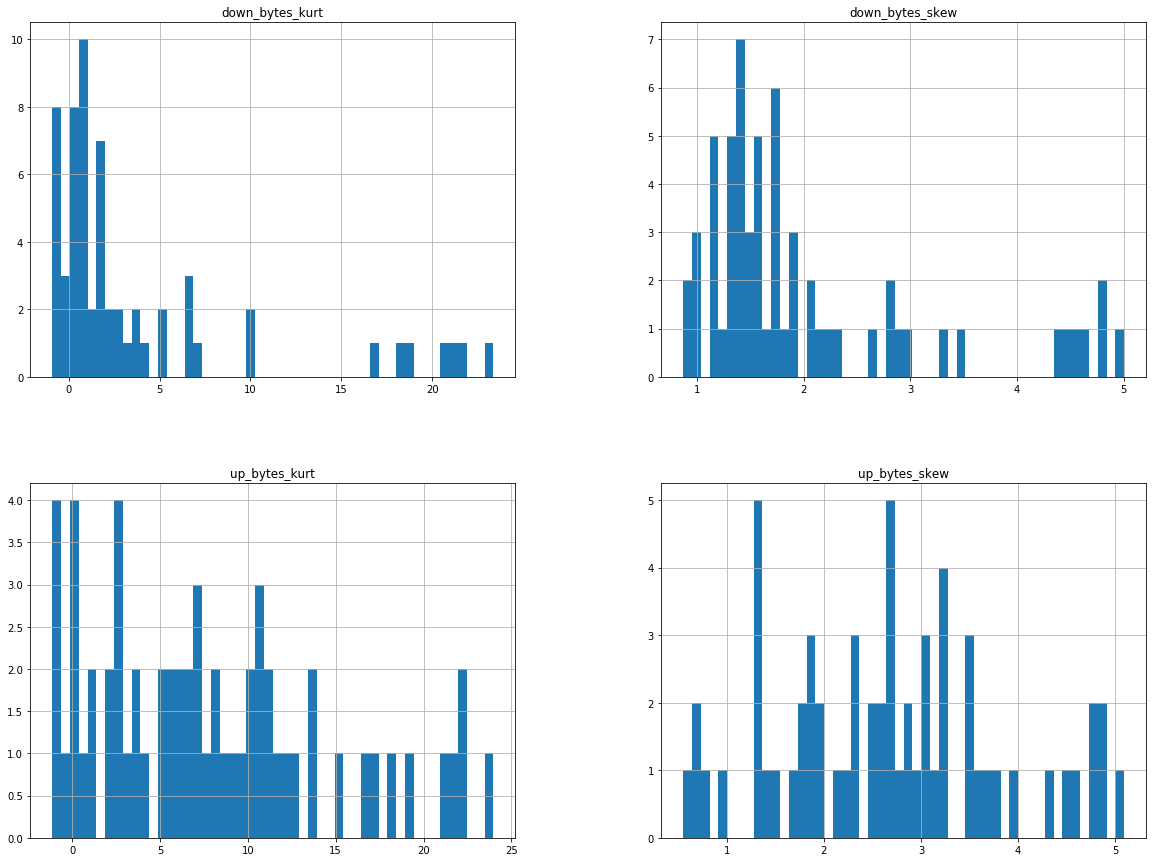

In [39]:
%matplotlib inline
df[['up_bytes_skew', 'down_bytes_skew', 'up_bytes_kurt', 'down_bytes_kurt']].hist(bins=50, figsize=(20,15))
plt.show()

## 

In [43]:
corr = df.corr()

up_bytes_mean         0.026949
up_bytes_median       0.077044
up_bytes_std         -0.022947
up_bytes_var          0.042497
up_bytes_skew         0.143037
up_bytes_kurt         0.211452
up_bytes_perc25       0.063866
up_bytes_perc50       0.077044
up_bytes_perc75       0.071562
up_packet_mean        0.096848
up_packet_median      0.089568
up_packet_std         0.097489
up_packet_var         0.108265
up_packet_skew       -0.019046
up_packet_kurt        0.024002
up_packet_perc25      0.063866
up_packet_perc50      0.089568
up_packet_perc75      0.099797
up_bytes_1max_y      -0.363639
up_bytes_2max_y      -0.279909
up_bytes_3max_y       0.505221
up_bytes_4max_y       0.356725
up_bytes_5max_y       0.145352
up_bytes_1max_x       1.000000
up_bytes_2max_x       0.696155
up_bytes_3max_x       0.572666
up_bytes_4max_x       0.358338
up_bytes_5max_x       0.144005
up_bytes_1min_y       0.572000
up_bytes_2min_y      -0.002188
                        ...   
down_bytes_1min_y     0.196978
down_byt